In [ ]:
%cd /content/drive/MyDrive/ML/Project/Cell Chain Model

/content/drive/MyDrive/ML/Project/Cell Chain Model


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold, train_test_split

In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=d7aa559ec92d06199f566747dc329b7589cdb452b3c3323e50a36eb45284fde6
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
from torchviz import make_dot

In [ ]:
# Create a class for the dataset
class MatchesDetailsDataset(Dataset):
    def __init__(self, matches_info, matches_details, targets):
        self.matches_info = matches_info
        self.matches_details = matches_details
        self.targets = targets

    def __len__(self):
        return len(self.matches_info)

    def __getitem__(self, idx):
        match_info = self.matches_info.iloc[idx].astype(np.float32).values
        print(match_info[0])
        match_details = self.matches_details[self.matches_details['id'] == match_info[0]].astype(np.float32).values
        target = self.targets[self.targets['id'] == match_info[0]].astype(np.float32).values

        # remove id
        return match_info[1:], match_details[:, 2:], target[:, 3:]

In [ ]:
matches_info = pd.read_csv('matches_info.csv')
matches_details = pd.read_csv('x_final.csv')
targets = pd.read_csv('y_final.csv')

In [ ]:
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# independant cell
class Cell(nn.Module):
    def __init__(self, input_size):
        super(Cell, self).__init__()
        self.input_size = input_size
        self.fc = nn.Sequential(
            nn.Linear(input_size, 1),
            nn.Tanh()
        )
        self.prev_fc = nn.Sequential(
            nn.Linear(input_size, input_size*2),
            nn.ReLU(),
            nn.Linear(input_size*2, 1),
            nn.Tanh()
        )
        self.next_fc = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU()
        )

    def forward(self, x, h = None):
        if h is None:
            return self.fc(x), self.next_fc(x)
        else:
            updated_features = self.prev_fc(h) + x
            return self.fc(updated_features), self.next_fc(updated_features)

# cell chain
class CellChain(nn.Module):
    def __init__(self, input_size, sequence_length, input_features):
        super(CellChain, self).__init__()
        self.input_size = input_size
        self.number_of_cells = sequence_length
        self.cells = nn.ModuleList()
        self.fc = nn.Sequential(
            nn.Linear(input_features, input_size),
            nn.Tanh()
        )
        self.out1_fc = nn.Sequential(
            nn.Linear(input_size, input_size*2),
            nn.ReLU(),
            nn.Linear(input_size*2, 1),
            nn.Tanh()
        )
        for _ in range(0, sequence_length):
            self.cells.append(Cell(input_size))

    def forward(self, x, h):
        outputs = []
        bias =  self.fc(h)
        out1 = self.out1_fc(bias)
        outputs.append(out1)
        for i in range(0, self.number_of_cells):
            out, h = self.cells[i](x[:, i, :] + bias, None if i == 0 else h)
            outputs.append(out)

        # return output[0] as single tensor
        result = torch.cat(outputs, dim=1)
        return result

In [ ]:
# train the model
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        train_losses = []
        test_losses = []

        for x, s, y in train_loader:
            optimizer.zero_grad()

            x = x.to(device)
            s = s.to(device)
            y = y.to(device)

            y_mod = torch.zeros(y[:, :, 1].shape[0], y[:, :, 1].shape[1] + 1).to(device)
            y_mod[:, 1:] = y[:, :, 1]
            y_mod[:, 0] = y[:, 0, 1]


            # Forward pass
            out = model(s, x)
            train_loss = criterion(out, y_mod)

            # Backward and optimize
            train_loss.backward()
            optimizer.step()

            train_losses.append(train_loss.item())
        
        # evaluate model
        model.eval()
        with torch.no_grad():
            for x, s, y in test_loader:
                x = x.to(device)
                s = s.to(device)
                y = y.to(device)

                y_mod = torch.zeros(y[:, :, 1].shape[0], y[:, :, 1].shape[1] + 1).to(device)
                y_mod[:, 1:] = y[:, :, 1]
                y_mod[:, 0] = y[:, 0, 1]

                # Forward pass
                out = model(s, x)
                test_loss = criterion(out, y_mod)

                test_losses.append(test_loss.item())
                
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {np.mean(train_losses):.4f}, Test Loss: {np.mean(test_losses):.4f}')

    return train_losses, test_losses

In [ ]:
def evaluate_model(model_winner, test, matches_details, targets, limit = None):
    test_loader = DataLoader(MatchesDetailsDataset(test, matches_details, targets), batch_size=1, shuffle=False)

    # set the model to evaluation
    model_winner.eval()
    with torch.no_grad():
        i = 0
        initial_correct = 0
        sanity_correct = 0

        total = 0
        for x, s, y in test_loader:
            x = x.to(device)
            s = s.to(device)
            y = y.to(device)

            y_mod = torch.zeros(y[:, :, 1].shape[0], y[:, :, 1].shape[1] + 1).to(device)
            y_mod[:, 1:] = y[:, :, 1]
            y_mod[:, 0] = y[:, 0, 1]

            s_pred = torch.full_like(s, 0).to(device)

            # Forward pass
            out = model_winner(s, x)

            true_output = y_mod[:, 0].item()

            initial_output = out[:, 0].item()

            

            #minimum index of y_mod with zero value
            zero_index = torch.where(y_mod == 0)[1]
            # check if zero index is not empty
            if zero_index.shape[0] != 0:
                last_pred = (torch.min(zero_index) - 1).item()
            else:
                last_pred = - 1

            sanity_output = out[:, last_pred].item()

            if true_output == 1:
                if initial_output > 0:
                    initial_correct += 1
                if sanity_output > 0:
                    sanity_correct += 1
            else:
                if initial_output < 0:
                    initial_correct += 1
                if sanity_output < 0:
                    sanity_correct += 1
            total += 1
            

            win_percentage_grapher(out.reshape(-1).cpu(), y_mod.reshape(-1).cpu())
            i += 1

            if limit != None:
              if limit == i:
                return initial_correct/total * 100, sanity_correct/total * 100

        
        
        return initial_correct/total * 100, sanity_correct/total * 100
    

In [ ]:
input_sequence_features = 18
sequence_length = 40
number_of_features = 30

In [ ]:
# Cross validation
def cross_validation(criterion, epochs, k=5):
    # split the data into k folds
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    # initialize a numpy array to store the accuracies
    accuracies = []
    # initialize a numpy array to store the accuracies
    accuracies_sanity = []
    # loop over the folds
    train_losses = []
    test_losses = []
    for i, (train_index, test_index) in tqdm(enumerate(kf.split(matches_info))):
        model_winner = CellChain(input_sequence_features, sequence_length, number_of_features)
        optimizer = optim.Adam(model_winner.parameters(), lr=0.001, weight_decay=0.001)

        model_winner.to(device)

        # split the data
        train = matches_info.iloc[train_index]
        test = matches_info.iloc[test_index]
        # create the data loaders
        train_loader = DataLoader(MatchesDetailsDataset(train, matches_details, targets), batch_size=32, shuffle=False)
        test_loader = DataLoader(MatchesDetailsDataset(test, matches_details, targets), batch_size=32, shuffle=False)
        # train the model
        model_winner.load_state_dict(torch.load(f'cell_chain_winner_model_v2_{i}.pt'))
        train_loss, test_loss = train_model(model_winner, train_loader, test_loader, optimizer, criterion, epochs)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        torch.save(model_winner.state_dict(), f'cell_chain_winner_model_v2.1_{i}.pt')

        # evaluate the model
        initial_accuracy, sanity_accuracy = evaluate_model(model_winner, test, matches_details, targets)

        print(f"Accuracy: {initial_accuracy}")
        print(f"Sanity: {sanity_accuracy}")

        # store the accuracy in the numpy array
        accuracies.append(initial_accuracy)
        accuracies_sanity.append(sanity_accuracy)
    # return the accuracies
    return accuracies, accuracies_sanity, train_losses, test_losses

In [ ]:
criterion = nn.MSELoss()

accuracies, accuracies_sanity, train_losses, test_losses = cross_validation(criterion, 100, k=5)

In [ ]:
np.mean(accuracies)

NameError: ignored

In [ ]:
np.mean(accuracies_sanity)

67.7794249528725

In [ ]:
accuracies

[51.06837606837607,
 51.49572649572649,
 64.66809421841542,
 52.24839400428265,
 52.03426124197003]

In [ ]:
accuracies_sanity

[67.09401709401709,
 67.94871794871796,
 67.02355460385438,
 69.593147751606,
 67.23768736616702]

In [ ]:
model_winner = CellChain(input_sequence_features, sequence_length, number_of_features)
model_winner.to(device)

In [ ]:
model_winner.load_state_dict(torch.load('cell_chain_winner_model_v2.1_0.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_index, test_index) in tqdm(enumerate(kf.split(matches_info))):
  
  test = matches_info.iloc[test_index]

  test_loader = DataLoader(MatchesDetailsDataset(test, matches_details, targets), batch_size=1, shuffle=False)
  break

0it [00:00, ?it/s]


In [ ]:
def win_percentage_grapher(model_output, true_output):
    team_2_win_percentage = list(map(lambda x: (x+1)/2 * 100, model_output))
    team_1_win_percentage = list(map(lambda x: 100 - x, team_2_win_percentage))

    plt.figure(figsize=(20, 10))

    # plot the win percentages against overs
    if true_output[0] == 1:
        plt.plot(team_2_win_percentage, label='Team 2 Win Percentage (winner)', color='red')
        plt.plot(team_1_win_percentage, label='Team 1 Win Percentage', color='blue')
    
    else:
        plt.plot(team_1_win_percentage, label='Team 1 Win Percentage (winner)', color='red')
        plt.plot(team_2_win_percentage, label='Team 2 Win Percentage', color='blue')

    plt.title('Win Percentage')
    plt.xlabel('Overs')
    plt.ylabel('Win Percentage')
    plt.legend()
    # x axis ticks
    plt.xticks(np.arange(0, 41, 1))
    for i in range(0, 41):
        plt.axvline(x=i, color='black', linestyle='dotted')

    plt.show()


1040485.0


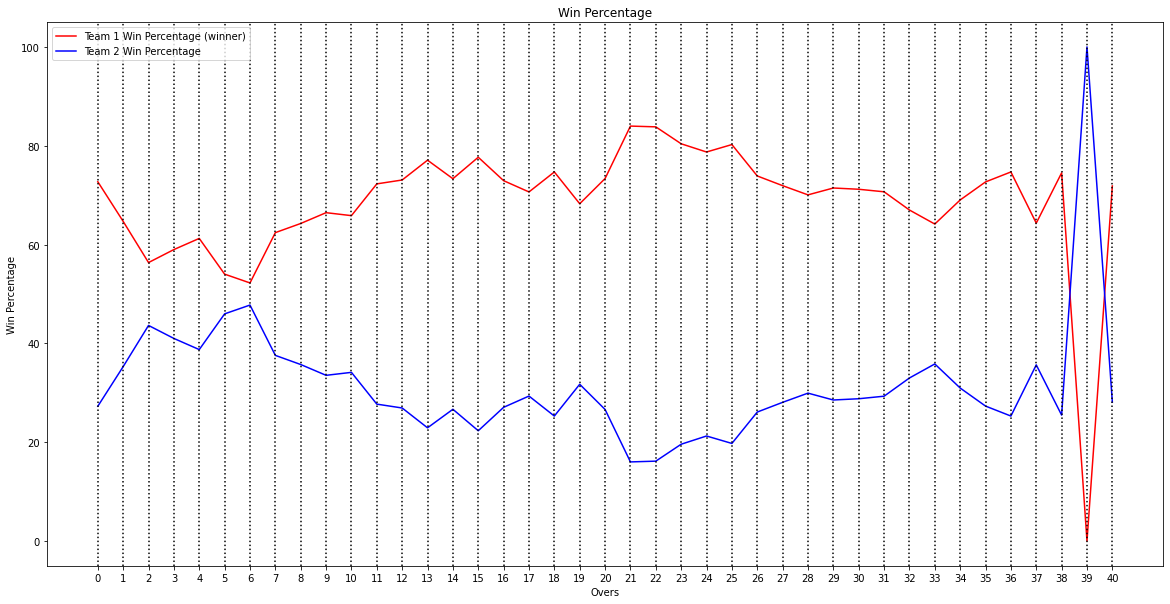

1043993.0


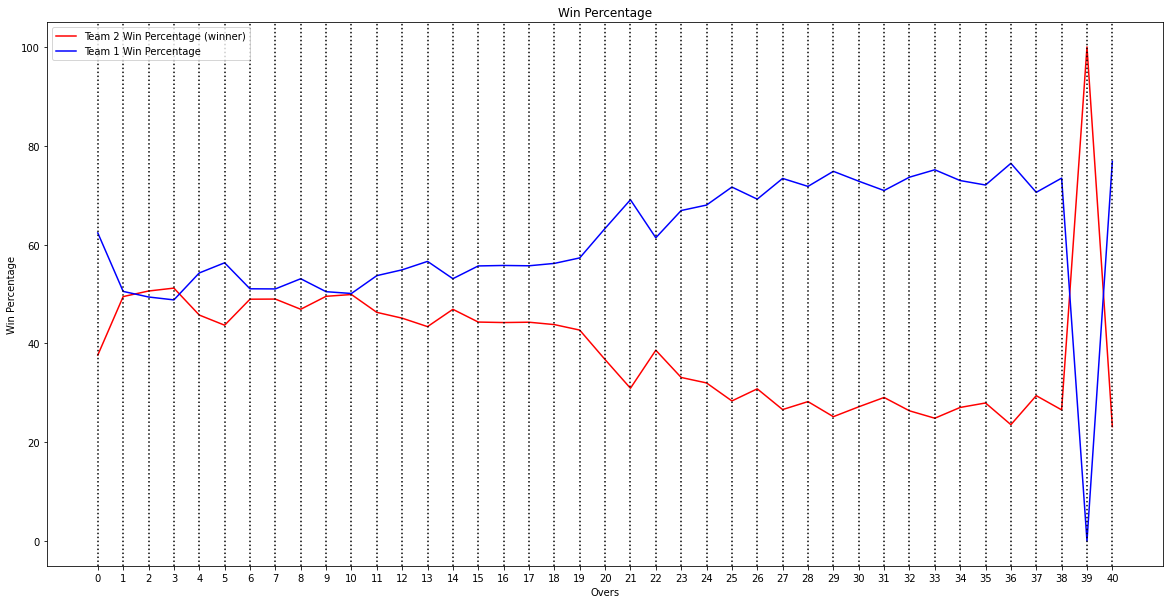

1050221.0


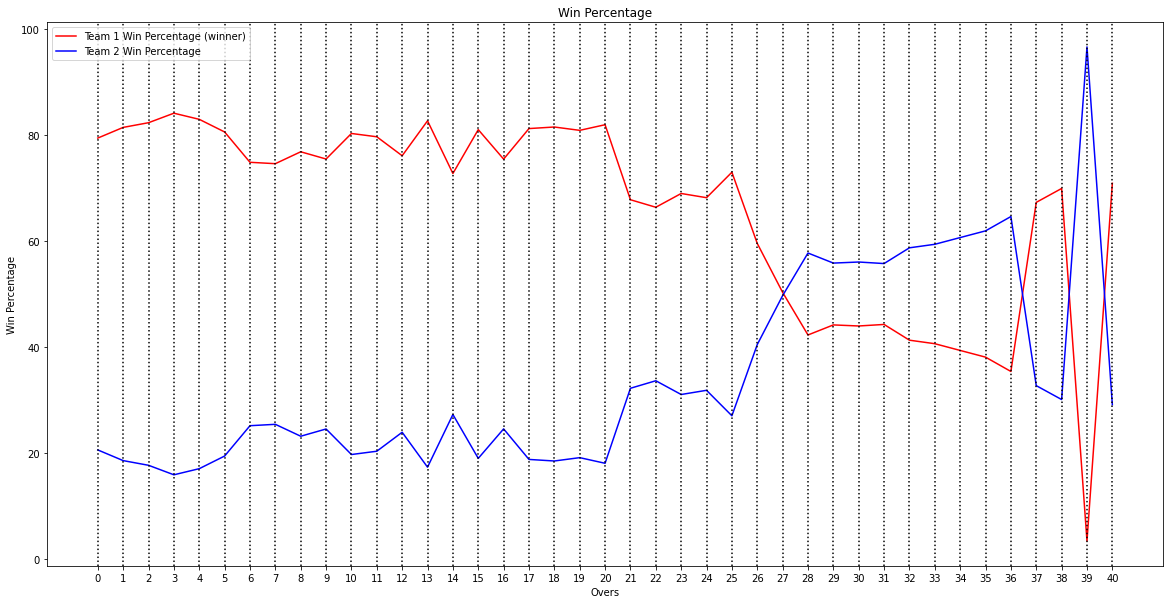

1074959.0


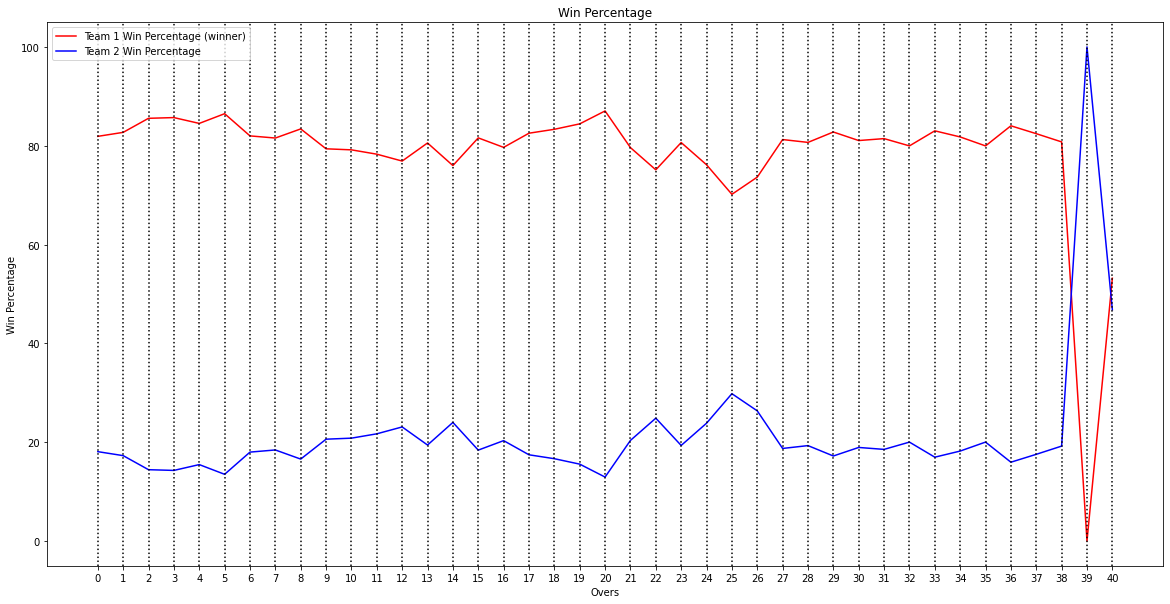

1074965.0


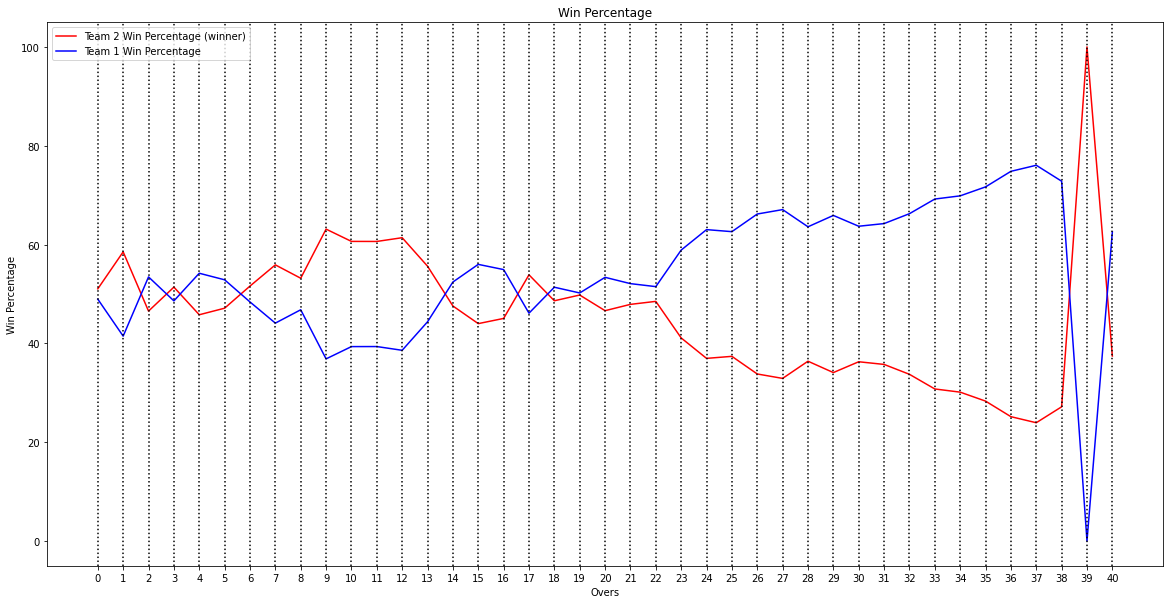

(80.0, 60.0)

In [ ]:
evaluate_model(model_winner, test, matches_details, targets, limit = 5)